In [1]:
#!imports
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent.parent
sys.path.append(str(PROJECT_ROOT))

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_theme()
import numpy as np
import random
import torch

from src.dag_learner.data import Data
from src.conformal_prediction.representation import  representation_class_based
from src.utils.dag import get_DAG, plot_graph
from src.utils.conformal import train_cp, train_cp_pca
from src.utils.utils import compute_TP, compute_TP_pca
from src.utils.data import sample_corrupted


np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

d = 4
n_train = 1000
n_test = 10000
s = d-1

sem_type = "mlp"
graph_type = "chain"
batch_size = n_train


data_config_train={
    "dim": d,
    "s0": s, 
    "n_train": n_train,
    "n_test": n_test,
    "sem_type": sem_type,
    "dag_type": graph_type,
    "batch_size": batch_size,
}



D_train = Data(**data_config_train)
D_train.setup()

X_train, X_test_clean = D_train.train.dataset[D_train.train.indices][0].numpy(), D_train.test.dataset[D_train.test.indices][0].numpy()



    

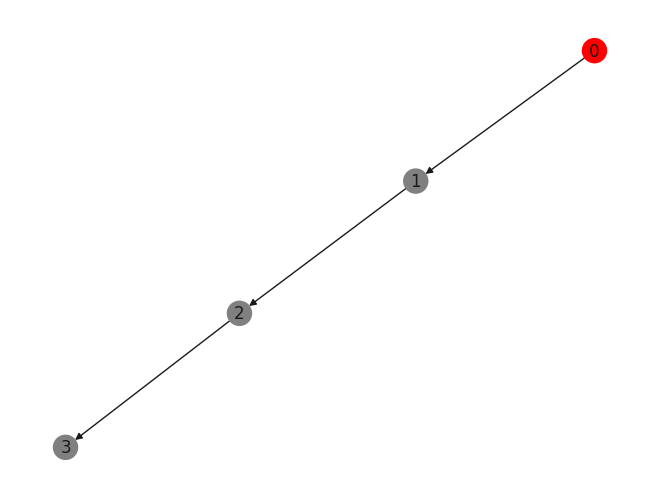

0it [00:00, ?it/s]

alpha: 0.025 cal_size: 0.2
DAGNOSIS GT


4it [00:04,  1.17s/it]
0it [00:00, ?it/s]

DATA SUITE


4it [00:03,  1.19it/s]


In [2]:
factor_pca = 2.
confidence = 0.1 
alpha = confidence/d
cal_size = 0.2

A_gt = get_DAG(D_train, "gt")
plot_graph(D_train.DAG, 0)


print(f"alpha: {alpha} cal_size: {cal_size}")

#Using the ground-truth DAG for now

##########################################
#### DAGNOSIS GT #########################
##########################################
print("DAGNOSIS GT")
list_features = np.arange(d)
list_conf_gt = train_cp(X_train, A_gt, list_features, alpha, cal_size)




##########################################
####### DATA-SUITE #######################
##########################################
print("DATA SUITE")

rep_dim = int(np.ceil(X_train.shape[1] / factor_pca))
pca_train, _, pca, scaler =  representation_class_based(X_train, X_train, rep_dim, "pca")
list_conf_pca = train_cp_pca(pca_train, X_train, list_features, alpha, cal_size)

In [3]:
n_corrupted = 10000
list_TPR_gain = []


# only corrupt the last feature
list_features_corruption = [d-1]
list_corruption_type = ["gaussian_noise"]*len(list_features_corruption)

print("Corrupted nodes: {}".format(list_features_corruption))

noise_mean_list = np.zeros(d)
X_test_corrupted, list_corrupted_SEMs, list_corrupted_parameters =sample_corrupted(D_train, n_corrupted, list_features_corruption, list_corruption_type, noise_mean_list=noise_mean_list, sample_last_layer=False, std_mlp = 2, mean_mlp =0)

_, conf_dict_gt = compute_TP(list_conf_gt, A_gt, X_test_corrupted)
_, conf_dict_pca = compute_TP_pca(list_conf_pca, scaler,pca, X_test_corrupted)
        


Corrupted nodes: [3]


In [4]:
# We compute, for each inconsistent samples, on how many features it was flagged
n_indices_flagged_list_dn = []
for row in range(len(X_test_corrupted)):
    n_indices_flagged = 0
    for feature in range(d):
        if not (conf_dict_gt[feature].iloc[row]["min"] <= conf_dict_gt[feature].iloc[row]["true_val"] <= conf_dict_gt[feature].iloc[row]["max"]):
            n_indices_flagged +=1
    if n_indices_flagged >0:
        #flagged at least on one feature
        n_indices_flagged_list_dn.append(n_indices_flagged)
print(f"DAGNOSIS: On average, the inconsistent samples were flagged on {np.mean(n_indices_flagged_list_dn)} features")
print(f"Std: {1.96*np.std(n_indices_flagged_list_dn)/np.sqrt(len(n_indices_flagged_list_dn))}")

        

DAGNOSIS: On average, the inconsistent samples were flagged on 1.0498 features
Std: 0.00452585857419341


In [5]:
n_indices_flagged_list_datasuite = []
for row in range(len(X_test_corrupted)):
    n_indices_flagged = 0
    for feature in range(d):
        if not (conf_dict_pca[feature].iloc[row]["min"] <= conf_dict_pca[feature].iloc[row]["true_val"] <= conf_dict_pca[feature].iloc[row]["max"]):
            n_indices_flagged +=1
    if n_indices_flagged >0:
        #flagged at least on one feature
        n_indices_flagged_list_datasuite.append(n_indices_flagged)
print(f"Data-SUITE: On average, the inconsistent samples were flagged on {np.mean(n_indices_flagged_list_datasuite)} features")
print(f"Std:{1.96*np.std(n_indices_flagged_list_datasuite)/np.sqrt(len(n_indices_flagged_list_datasuite))}")

Data-SUITE: On average, the inconsistent samples were flagged on 3.4761 features
Std:0.014849878786252768
